## Question 5
- Here the network we are using is:  Yeast Interactome. 
- Here's the link for the same: http://interactome.dfci.harvard.edu/S_cerevisiae/download/Y2H_union.txt

### RAW DATA TO CSV DATA
We are given the network in a `.txt` file containing raw data in the format: `node1 node2`, representing an undirected edge between `node1` and `node2`.  
To process this data efficiently, we convert it into a `.csv` file with two columns: `u` and `v`.

In [2]:
import pandas as pd

with open("yeast_interactome_dataset.txt") as file:
    filtered_data=[]
    data=file.readlines()
    for item in data:
        item=item.strip()
        item=item.split(' ')
        filtered_data.append([item[0],item[1]])
    dataframe=pd.DataFrame(filtered_data)
    dataframe.columns=["u","v"]
    dataframe.to_csv("yeast_data.csv",index=False)
    

## PART-A

### Representing the Yeast Interactome In a Adjacency Matrix

In [3]:
dataframe = pd.read_csv("yeast_data.csv")

PROTEIN_TO_NUM_MAP = {}
counter=0
for index,row in dataframe.iterrows():
    u=row.iloc[0]
    v=row.iloc[1]
    if(PROTEIN_TO_NUM_MAP.get(u)==None):
        PROTEIN_TO_NUM_MAP[u]=counter
        counter+=1
    if(PROTEIN_TO_NUM_MAP.get(v)==None):
        PROTEIN_TO_NUM_MAP[v]=counter
        counter+=1

ADJ_SIZE = counter
ADJ_MATRIX=[]
ADJ_ROW=[]
for i in range(ADJ_SIZE):
    ADJ_ROW.append(0)

for i in range(ADJ_SIZE):
    ADJ_MATRIX.append(list(ADJ_ROW))

for index,row in dataframe.iterrows():
    u=row.iloc[0]
    v=row.iloc[1]
    u_num = PROTEIN_TO_NUM_MAP[u]
    v_num = PROTEIN_TO_NUM_MAP[v]
    ADJ_MATRIX[u_num][v_num]=1
    ADJ_MATRIX[v_num][u_num]=1

### Plotting the Degree Distribution on a log-log Scale

To obtain the probabilites that a node has degree `k`, we first find the maximum possible degree in our network, by simply summing across each row in adjacency matrix and then finding the maximum across them.

Next, we precompute the degrees of each node by the same logic as used in the previous step and store them at `kth` index in a array.

Now, we run a simple for loop across the array and get the total number of nodes for that degree and then we divide this by total number of nodes present in out network.

Effective Formula: `P(k) = Nk/N`

Next, we simply plot this data using matplotlib and label the axes as well.

The degree distribution confirms the presence of hubs in the Yeast Network. 

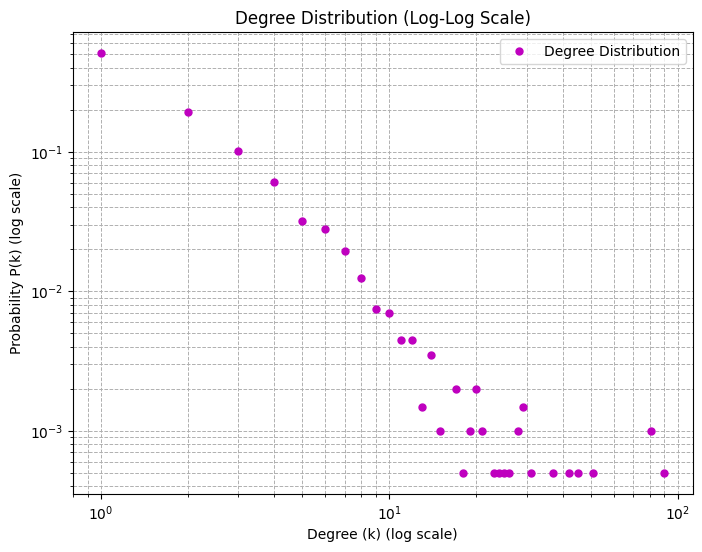

In [6]:
# degree distribution
import matplotlib.pyplot as plt


def max_possible_degree(adj_matrix):
    degrees=[]
    for i in range(len(adj_matrix)):
        my_degree=0
        for j in range(len(adj_matrix)):
            if(adj_matrix[i][j]==1):
                my_degree+=1
        degrees.append(my_degree)
    max_val = max(degrees)
    return max_val

def calculate_nodes_with_degree(adj_matrix):
    degrees=[0]*len(adj_matrix)
    for i in range(len(adj_matrix)):
        for j in range(len(adj_matrix)):
            if(adj_matrix[i][j]==1):
                degrees[i]+=1
    return degrees

max_degree_in_network=max_possible_degree(ADJ_MATRIX)

node_degrees=calculate_nodes_with_degree(ADJ_MATRIX)
probabiltiy_and_degree_data=[]

degree_count = [0] * (max_degree_in_network + 1)

for i in range(len(node_degrees)):
    degree_count[node_degrees[i]] += 1

for i in range(max_degree_in_network+1):
    pk = degree_count[i] / len(ADJ_MATRIX)
    probabiltiy_and_degree_data.append([pk, i])

probabilities, degrees = zip(*probabiltiy_and_degree_data)

plt.figure(figsize=(8, 6))
plt.loglog(degrees, probabilities, 'mo', linewidth=1, markersize=5, label='Degree Distribution')

plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree (k) (log scale)')
plt.ylabel('Probability P(k) (log scale)')
plt.grid(True, which="both", linestyle='--', linewidth=0.7)
plt.legend()
plt.savefig('q5_part(a)_degree_distribution_loglog.png', dpi=1000, bbox_inches='tight')
plt.show()




### Plotting Clustering Coefficient vs Degree

Formula used:-
- Clustering Coefficient (C) = (2 * Number of Actual Edges Between Neighbors) / (Degree of Node * (Degree of Node - 1))
  
Where:
- **Number of Actual Edges Between Neighbors** is the number of edges that actually exist between the neighbors of the node.
- **Degree of Node** is the number of neighbors connected to the node.

After Obtaining the Clustering Coefficient for a set of degrees, we simply stored them and then plotted them using matplotlib. 

Average Clustering Coeffficient is:  0.08397718749419945


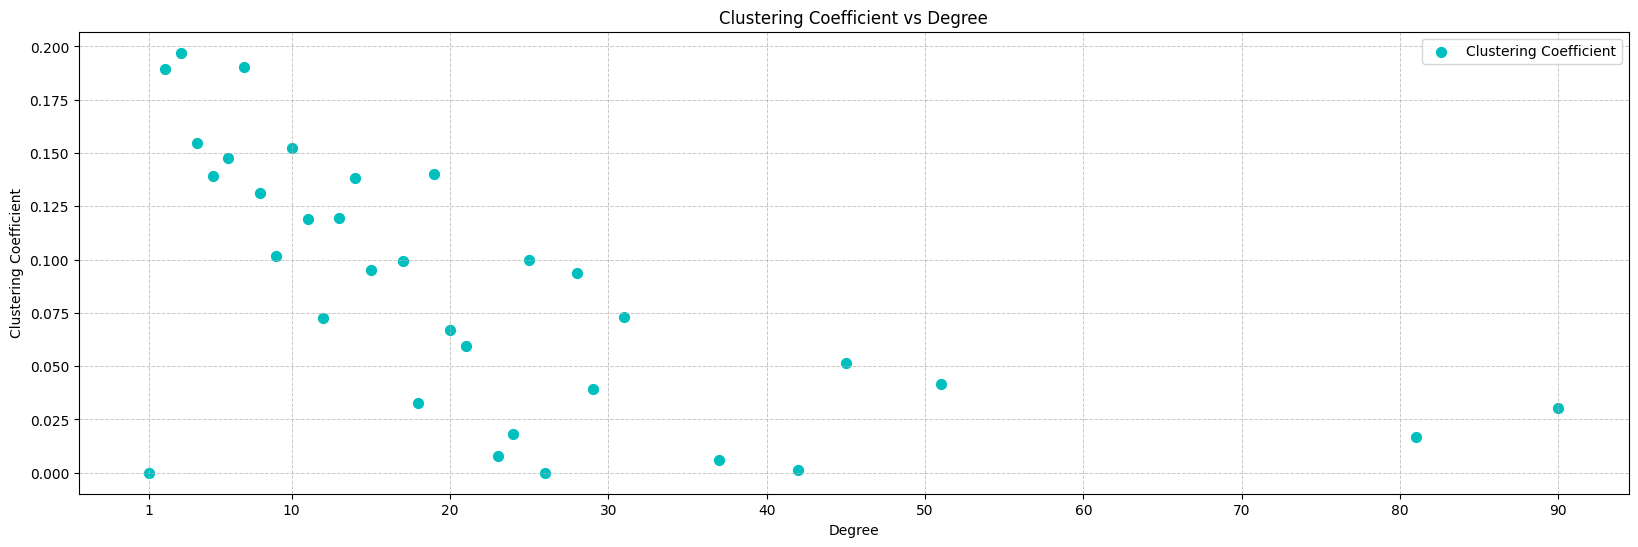

In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

def find_clustering_coefficient(adj_matrix):
    num_nodes=len(adj_matrix)

    all_data=[] # coefficient,degree
    for src in range(num_nodes):
        degree=0
        neighbours=[]
        comman_edge=0
        for dst in range(num_nodes):
            if(adj_matrix[src][dst]==1):
                degree+=1
                neighbours.append(dst)

        if(degree < 2):
            all_data.append([0,degree])
            continue

        for i in range(degree):
            for j in range(i + 1, degree):
                if adj_matrix[neighbours[i]][neighbours[j]] == 1:
                    comman_edge += 1

        coefficinet=(2*(comman_edge))/(degree*(degree-1))
        all_data.append([coefficinet,degree])

    return all_data


coefficients=find_clustering_coefficient(ADJ_MATRIX)
sorted_list = sorted(coefficients, key=lambda x: x[1])
sum_coefficient=0
sorted_coefficinets=[]
sorted_degrees=[]
for i in sorted_list:
    sum_coefficient+=i[0]
    sorted_coefficinets.append(i[0])
    sorted_degrees.append(i[1])


grouped = defaultdict(lambda: [0, 0])  

for first, second in sorted_list:
    grouped[second][0] += first  
    grouped[second][1] += 1      
means = {key: total / count for key, (total, count) in grouped.items()}

avg_clustering_coefficient=sum_coefficient/len(coefficients)
print("Average Clustering Coeffficient is: ",avg_clustering_coefficient)
sorted_degrees=[]
sorted_coefficinets=[]
for key,val in means.items():
    sorted_degrees.append(key)
    sorted_coefficinets.append(val)
plt.figure(figsize=(20, 6))  

plt.scatter(sorted_degrees, sorted_coefficinets, color='c', s=50, label='Clustering Coefficient')

x_min, x_max = min(sorted_degrees), max(sorted_degrees)
plt.xticks(np.linspace(x_min, x_max, num=10, dtype=int))
plt.title('Clustering Coefficient vs Degree')  
plt.xlabel('Degree')
plt.ylabel('Clustering Coefficient')
plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)  
plt.legend()

plt.savefig('q5_part(a)_clustering_coefficient_distribution.png', dpi=1000, bbox_inches='tight')  
plt.show()


## Visualization In Cytoscape: Yeast Interactome
![Visualization In Cytoscape: Yeast Interactome](yeast_interactome.png)


### Finding the Max Degree Protein

- To find the maximum degree protein, we simply run a for loop over the adjacency matrix anf for each row we sum all the values.
- This gives us the degree for the particular node.
- Next, we simply lookup in the dictionary created earlier to find the protein name.

In [11]:
MAX_DEGREE  = -1
MAX_DEGREE_PROTEIN = ""

for node in range(len(ADJ_MATRIX)):
    degree_of_this_node = sum(ADJ_MATRIX[node])
    if(degree_of_this_node > MAX_DEGREE):
        MAX_DEGREE=degree_of_this_node
        for key,value in PROTEIN_TO_NUM_MAP.items():
            if(value==node):
                MAX_DEGREE_PROTEIN=key

print("The maximum Degree in the network is: ",MAX_DEGREE)
print("The Max Degree Protein is: ",MAX_DEGREE_PROTEIN)



The maximum Degree in the network is:  90
The Max Degree Protein is:  YLR291C


### Imortance of the Highest degree protein: YLR291C

- The protein encoded by the YLR291C is known as: GDC7.
- This protein is a subunit of eukaryotic translation initiation factor 2B (eIF2B) complex.
- This helps in initiation phase of the protein synthesis. 
- Speficic functions of the protein is to work as a guanine nucleotide exchange factor (GEF), and thus it helps in the exchange of the GDP for GTP. 
- Thus, this protein plays a huge role in the initiation of translation. 
- Sources: https://www.yeastgenome.org/locus/YLR291C

## PART-B

This was removed from the questions.

## PART-C

For this part we reused the code of q4, and simply created the numerical yeast network csv, which had numbers instead of protein. And then we simply used the functions of q4 and plotted the graphs.

In [6]:
dataframe = pd.read_csv("yeast_data.csv")

data = []
for index, row in dataframe.iterrows():
    u = row.iloc[0]
    v = row.iloc[1]
    data.append([PROTEIN_TO_NUM_MAP[u], PROTEIN_TO_NUM_MAP[v]])
data = pd.DataFrame(data)
data.to_csv("numerical_yeast_data.csv", index=False)

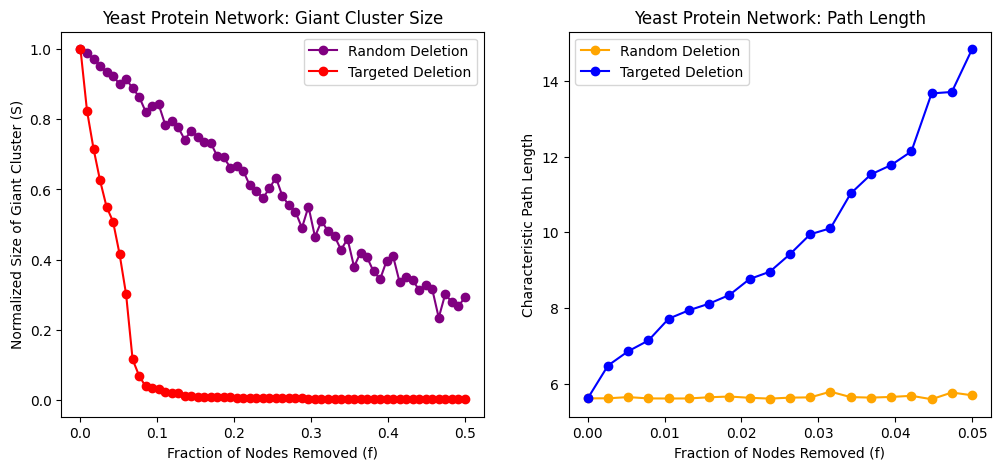

In [15]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

def deleteRandomNode(adj_matrix,flag):
    if(flag==0):
        fractions = np.linspace(0, 0.05, 20)
    else:
        fractions = np.linspace(0, 0.5, 60)
    G = nx.from_numpy_array(adj_matrix)
    nodes = list(G.nodes())

    path_lengths = []
    giant_cluster_sizes = []
    initial_largest_cc_size = len(max(nx.connected_components(G), key=len))

    for f in fractions:
        G_copy = G.copy()
        num_remove = int(f * len(nodes))
        remove_nodes = random.sample(nodes, num_remove)
        G_copy.remove_nodes_from(remove_nodes)

        b = nx.connected_components(G_copy)
        components = list(b)
        if components:
            largest_cc = max(components, key=len)
            H = G_copy.subgraph(largest_cc)
            giant_cluster_sizes.append(len(largest_cc)/initial_largest_cc_size)
            if nx.is_connected(H):
                a = nx.average_shortest_path_length(H)
                path_lengths.append(a)
            else:
                path_lengths.append(np.nan)
        else:
            giant_cluster_sizes.append(0)
            path_lengths.append(np.nan)
    if(flag==0):
        return path_lengths, fractions
    else:
        return giant_cluster_sizes, fractions


def deleteTargetNode(G,flag):
    if(flag==0):
        fractions = np.linspace(0, 0.05, 20)
    else:
        fractions = np.linspace(0, 0.5, 60)
    nodes = sorted(G.nodes(), key=lambda x: G.degree[x], reverse=True)  # Sort by degree

    path_lengths = []
    giant_cluster_sizes = []
    initial_largest_cc_size = len(max(nx.connected_components(G), key=len))

    for f in fractions:
        G_copy = G.copy()
        num_remove = int(f * len(nodes))
        remove_nodes = nodes[:num_remove]  # Remove highest-degree nodes first
        G_copy.remove_nodes_from(remove_nodes)

        components = list(nx.connected_components(G_copy))
        if components:
            largest_cc = max(components, key=len)
            H = G_copy.subgraph(largest_cc)
            giant_cluster_sizes.append(len(largest_cc)/initial_largest_cc_size)
            if nx.is_connected(H):
                path_lengths.append(nx.average_shortest_path_length(H))
            else:
                path_lengths.append(np.nan)
        else:
            giant_cluster_sizes.append(0)
            path_lengths.append(np.nan)
    if(flag==0):
        return path_lengths, fractions
    else:
        return giant_cluster_sizes, fractions




real_network = nx.read_edgelist("numerical_yeast_data.csv", nodetype=int,delimiter=",")  

# chlo phele path length nikal lu
real_random_path, path_fractions = deleteRandomNode(nx.to_numpy_array(real_network),0)
real_target_path, path_fractions = deleteTargetNode(real_network,0)

# chlo ab cluster size nikal lu
real_random_giant, cluster_fractions = deleteRandomNode(nx.to_numpy_array(real_network),1)
real_target_giant, cluster_fractions = deleteTargetNode(real_network,1)


plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cluster_fractions, real_random_giant,'o-',color='purple', label="Random Deletion")
plt.plot(cluster_fractions, real_target_giant,'o-', color='red',label="Targeted Deletion")
plt.xlabel("Fraction of Nodes Removed (f)")
plt.ylabel("Normalized Size of Giant Cluster (S)")
plt.title("Yeast Protein Network: Giant Cluster Size")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(path_fractions, real_random_path,'o-', color='orange',label="Random Deletion")
plt.plot(path_fractions, real_target_path, 'o-',color='blue',label="Targeted Deletion")
plt.xlabel("Fraction of Nodes Removed (f)")
plt.ylabel("Characteristic Path Length")
plt.title("Yeast Protein Network: Path Length")
plt.legend()

plt.show()


As expected both the graphs follow the same trend of the Albert et al., Nature, 406, 378 (2000).
- The path length increases for targeted attack as we increase the number of nodes removed and remains constant for random deletion.
- The size of giant cluster decreases sharply for targeted attack and the critical fraction of node point(fc) occurs just before 0.1, and it shows a linear decrease pattern for random deletion. 
- Both of these aligns with the trends of the scale free graphs. 
- Thus, it proves tha Yeast Protein Network is also a scale free network. 

#### Avg Size of Fragmented Components

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt

def avg_fragmented_component_size(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)  
    nodes = list(G.nodes())
    fractions = np.linspace(0, 0.5, 20)

    avg_fragment_sizes = []

    for f in fractions:
        G_temp = G.copy()
        b = f * len(nodes)
        num_remove = int(b)  
        remove_nodes = random.sample(nodes, num_remove)
        G_temp.remove_nodes_from(remove_nodes)

        components = list(nx.connected_components(G_temp))

        if components:
            sizes = [] 
            for c in components: 
                sizes.append(len(c))

            largestSize = max(sizes)
            fragmented_sizes = [] 

            for s in sizes:
                if s != largestSize: 
                    fragmented_sizes.append(s) 

            if fragmented_sizes:
                a = np.mean(fragmented_sizes)
                avg_fragment_sizes.append(a)  
            else:
                avg_fragment_sizes.append(0)
        else:
            avg_fragment_sizes.append(0)  

    return avg_fragment_sizes, fractions

def avg_fragmented_component_size_targeted(adj_matrix):
    G = nx.from_numpy_array(adj_matrix)
    nodes = list(G.nodes())
    fractions = np.linspace(0, 0.5, 20) 

    avg_fragment_sizes = []

    for f in fractions:
        G_temp = G.copy()
        b = f * len(nodes)
        num_remove = int(b)  

        x = G_temp.degree()
        degree_sorted_nodes = sorted(x, key=lambda x: x[1], reverse=True)
        remove_nodes = []  

        for i in range(num_remove):
            node, _ = degree_sorted_nodes[i]
            remove_nodes.append(node)

        G_temp.remove_nodes_from(remove_nodes)

        components = list(nx.connected_components(G_temp))

        if components:
            sizes = []
            for c in components:
                size = len(c) 
                sizes.append(size)  

            if sizes:
                largest_size = max(sizes)
            else:
                largest_size = 0

            fragmented_sizes = []  

            for s in sizes:
                if s != largest_size: 
                    fragmented_sizes.append(s) 
            
            avg_fragment_sizes.append(np.mean(fragmented_sizes) if fragmented_sizes else 0)
        else:
            avg_fragment_sizes.append(0) 

    return avg_fragment_sizes, fractions

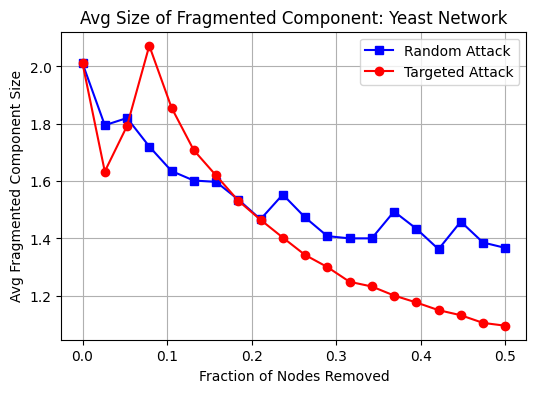

In [3]:
def plot_fragmentation_combined(adj_matrix):
    avg_sizes_random, fractions = avg_fragmented_component_size(adj_matrix)
    avg_sizes_targeted, _ = avg_fragmented_component_size_targeted(adj_matrix)
    
    plt.figure(figsize=(6, 4))
    plt.plot(fractions, avg_sizes_random, 's-', color='blue', label="Random Attack")
    plt.plot(fractions, avg_sizes_targeted, 'o-', color='red', label="Targeted Attack")
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Avg Fragmented Component Size")
    plt.title("Avg Size of Fragmented Component: Yeast Network")
    plt.legend()
    plt.grid(True)
    plt.show()

real_network = nx.read_edgelist("numerical_yeast_data.csv", nodetype=int, delimiter=",")
adj_matrix = nx.to_numpy_array(real_network, nodelist=sorted(real_network.nodes()))
plot_fragmentation_combined(adj_matrix)

- In case of random deletion the the avg size of fragmented component `<s>` decreases slowly, there are some fluctuations in the graph but overall decreasing pattern is linear.
- In case of targeted deletion, the size first increases, and then it decreases sharply. 
- This suggests that scale free networks are tolerable to random node deletions, but for a targeted attack, they are vulnerable. 
- Thus, this is in accordance with the Albert et al (2000), which proves that scale free networks are vulnerable to targeted node deletions. 